### 2. **Linear Regression 2**

#### 2.1. **Getting Started**

In [53]:
# Append the path to useful directories
import sys
sys.path.append('../my_functions')

# Packages needed
from download_dataset import download_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Download and extract the dataset
fishcatch = download_dataset(data_file='fishcatch', extension='.tar.xz')

# Quick peek at the data
df = pd.read_csv(fishcatch)
df.head(3).style.background_gradient(cmap='viridis')

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.000000,23.200000,25.400000,30.000000,11.520000,4.020000
1,Bream,290.000000,24.000000,26.300000,31.200000,12.480000,4.305600
2,Bream,340.000000,23.900000,26.500000,31.100000,12.377800,4.696100


As seen before, the 'Weight' variable seems to have a non-linear relationship with the 'Width' variable.

Is it possible to improve the model if we remove the 'Weight' variable from the analysis? Let's try it.

The next steps are the same as before, but without the 'Weight' variable.


In [54]:
# Dropping the weigth column from the dataset
df = df.drop(columns=['Weight'])
df.head(3).style.background_gradient(cmap='viridis')

,Species,Length1,Length2,Length3,Height,Width
0,Bream,23.200000,25.400000,30.000000,11.520000,4.020000
1,Bream,24.000000,26.300000,31.200000,12.480000,4.305600
2,Bream,23.900000,26.500000,31.100000,12.377800,4.696100


#### 2.2. **Droping the 'Species' variable**


In [55]:
# Including only the numeric columns
df_no_species = df.select_dtypes(include=['int64', 'float64'])
df_no_species.head(3).style.background_gradient(cmap='viridis')

,Length1,Length2,Length3,Height,Width
0,23.200000,25.400000,30.000000,11.520000,4.020000
1,24.000000,26.300000,31.200000,12.480000,4.305600
2,23.900000,26.500000,31.100000,12.377800,4.696100


After dropping the 'Species' variable, we will split the data into training and testing sets, fit the model and evaluate it.


In [56]:
# Splitting the dataset into features and target variable
X = df_no_species.drop(columns=['Width'])
y = df_no_species['Width']

In [57]:
# Split the dataset into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [58]:
# Fitting the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [59]:
# R2 score of the training set
train_r2 = lr.score(X_train, y_train)
print(f'Training R²: {train_r2:.3f}')

Training R²: 0.906


In [60]:
# Where the model intercepts the y-axis
intercept = lr.intercept_
print(f'Intercept: {intercept}')

# The coefficients of the model
coef = lr.coef_
print(f'Coefficients: {coef}')

Intercept: 0.3619667383985803
Coefficients: [ 0.07588865  0.55324586 -0.531129    0.33017862]


In [61]:
# Equation of the line
print(f"{y.name} = \n{intercept:.6f} ")
for i, j in zip(X.columns, coef):
    print(f"+ {i}*{j:.6f}")

Width = 
0.361967 
+ Length1*0.075889
+ Length2*0.553246
+ Length3*-0.531129
+ Height*0.330179


In [62]:
# Testing the model
y_pred = lr.predict(X_test)
y_pred

array([3.3953556 , 1.74220507, 3.86361266, 4.06095768, 3.39065965,
       7.0074338 , 1.40243248, 3.61607909, 3.99454315, 7.10993082,
       5.47249799, 6.2973627 , 5.6362591 , 3.8621578 , 5.99796093,
       6.8506447 , 7.20852243, 4.41530646, 4.1736207 , 5.49044053,
       1.5210021 , 5.90076508, 5.20746891, 4.97989032, 6.91930902,
       7.15966379, 3.78849611, 3.97925555, 1.32746193, 1.5210021 ,
       4.99756109, 2.8688694 ])

In [63]:
# Performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.17083217471977818
Root Mean Squared Error: 0.41331849065796483
Mean Absolute Error: 0.34840955843277266
R2 Score: 0.9513143498200114


In [64]:
# Save the results to a csv file
from save_results import save_results
save_results(mse, mae, r2, rmse, train_r2, 'Linear Regression 2: with no species')

Results saved successfully to "results.csv".


More information about the function below in [plot_regression.py](../my_functions/plot_regression.py).


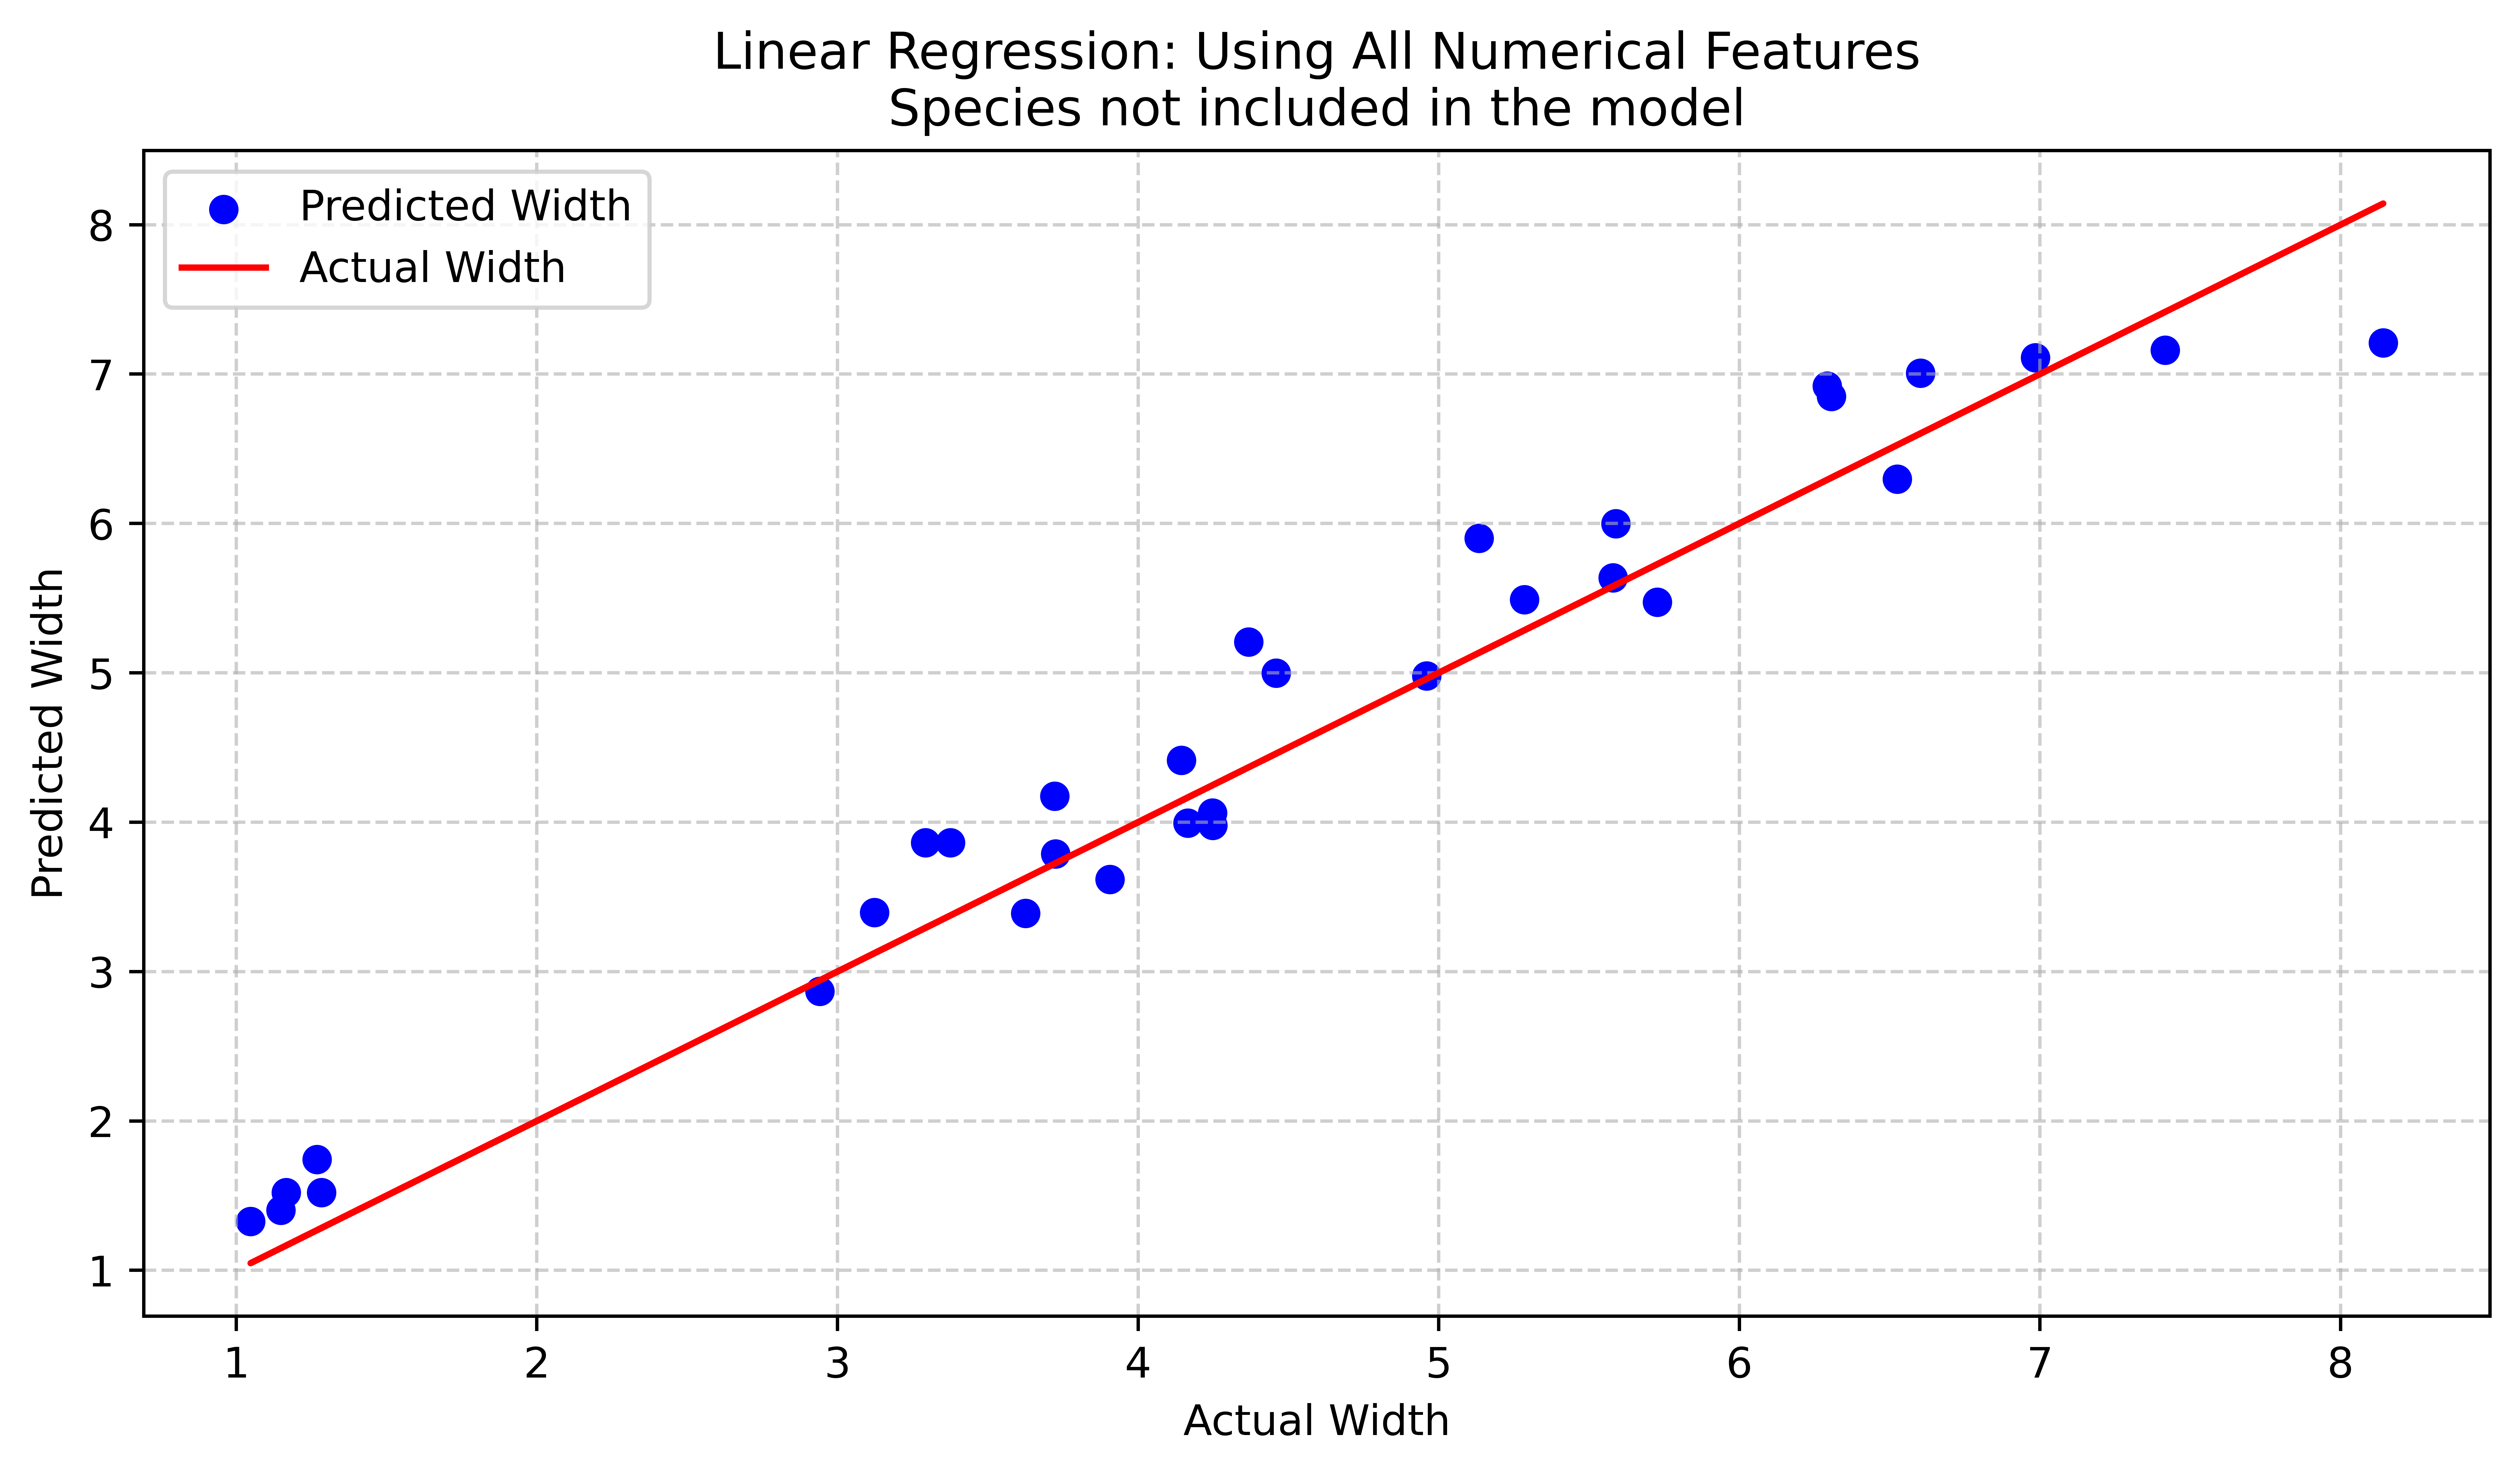

In [65]:
# Plotting the model
from plot_regression import plot_regression
plot_regression(
    y_test, y_pred,
    regression_type='Linear',
    title="Using All Numerical Features\nSpecies not included in the model")

The results achieved with this model are not bad, but we can try to improve it by using the 'Species' variable as a predictor.


#### 2.3. **Using the 'Species' variable**

The species are categorical variables, so encoding them is necessary. The class/method below is encoding the species using the OneHotEncoder from Scikit-learn.

What the OneHotEncoder does is to create a binary column for each category and returns a sparse matrix or dense array.


In [66]:
from sklearn.preprocessing import OneHotEncoder

# Encoding the Species column
encoder = OneHotEncoder()
encoder.handle_unknown = 'ignore'

# Turning the Species column into a numpy array with new columns
# for each species. 1: True, 0: False
species_encoded = encoder.fit_transform(df[['Species']])
species_encoded.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [67]:
# All the categories in the Species column
encoder.categories_

[array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
       dtype=object)]

In [68]:
# Combine the encoded species with the original dataset
encoder.get_feature_names_out()

df_output = pd.DataFrame(encoder.transform(df[['Species']]).toarray(),

                         columns=encoder.categories_[0].tolist(),

                         index=df.index)


df_with_species = pd.concat(
    [df_output, df.drop(columns=['Species'])], axis=1)

df_with_species.head(3).style.background_gradient(cmap='viridis')

,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish,Length1,Length2,Length3,Height,Width
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,25.400000,30.000000,11.520000,4.020000
1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,26.300000,31.200000,12.480000,4.305600
2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.900000,26.500000,31.100000,12.377800,4.696100


Combining the encoded species with the other variables, the dataset is ready to be split into training and test sets.


In [69]:
# Splitting the dataset into features and target variable
X = df_with_species.drop(columns=['Width'])
y = df_with_species['Width']

In [70]:
# Split the dataset into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [71]:
# Fitting the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [72]:
# R2 score of the training set
train_r2 = lr.score(X_train, y_train)
print(f'Training R²: {train_r2:.2f}')

Training R²: 0.96


The training set has a high R2 score, which is a good indication that the model is fitting the data well.

Later on, we have to check the performance of the model on the test set, that is, how well the model generalizes to new data.

In [73]:
# Where the model intercepts the y-axis
intercept = lr.intercept_
print(f'Intercept: {intercept}')

# The coefficients of the model
coef = lr.coef_
print(f'Coefficients: {coef}')

Intercept: -0.6901861832884713
Coefficients: [-1.73225663 -0.73808206  0.89269345  0.01337126  0.3501394   0.44245079
  0.77168379  0.13612269 -0.22947503  0.15818241  0.3515884 ]


In [74]:
# Equation of the line
print(f"{y.name} = \n{intercept:.6f} ")
for i, j in zip(X.columns, coef):
    print(f"+ {i}*{j:.6f}")

Width = 
-0.690186 
+ Bream*-1.732257
+ Parkki*-0.738082
+ Perch*0.892693
+ Pike*0.013371
+ Roach*0.350139
+ Smelt*0.442451
+ Whitefish*0.771684
+ Length1*0.136123
+ Length2*-0.229475
+ Length3*0.158182
+ Height*0.351588


In [75]:
# Testing the model
y_pred = lr.predict(X_test)
y_pred

array([3.09490237, 1.48923192, 3.45721404, 4.81392864, 3.49339094,
       7.05072278, 1.13726969, 3.99453327, 4.14555854, 6.75163168,
       5.32042618, 7.20433026, 5.54857036, 3.15677976, 6.00460361,
       6.82447138, 7.40028621, 4.47377908, 4.28759114, 5.4261412 ,
       1.43321665, 5.69855694, 4.90567853, 5.14028089, 6.82521296,
       7.39014991, 3.89725911, 4.77953863, 1.08906216, 1.43321665,
       4.61229393, 2.88622996])

In [76]:
# Performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.12820314641785713
Root Mean Squared Error: 0.3580546695937048
Mean Absolute Error: 0.28148963076188904
R2 Score: 0.9634632436851427


In [77]:
save_results(mse, mae, r2, rmse, train_r2, 'Linear Regression 2: encoded species')

Results saved successfully to "results.csv".


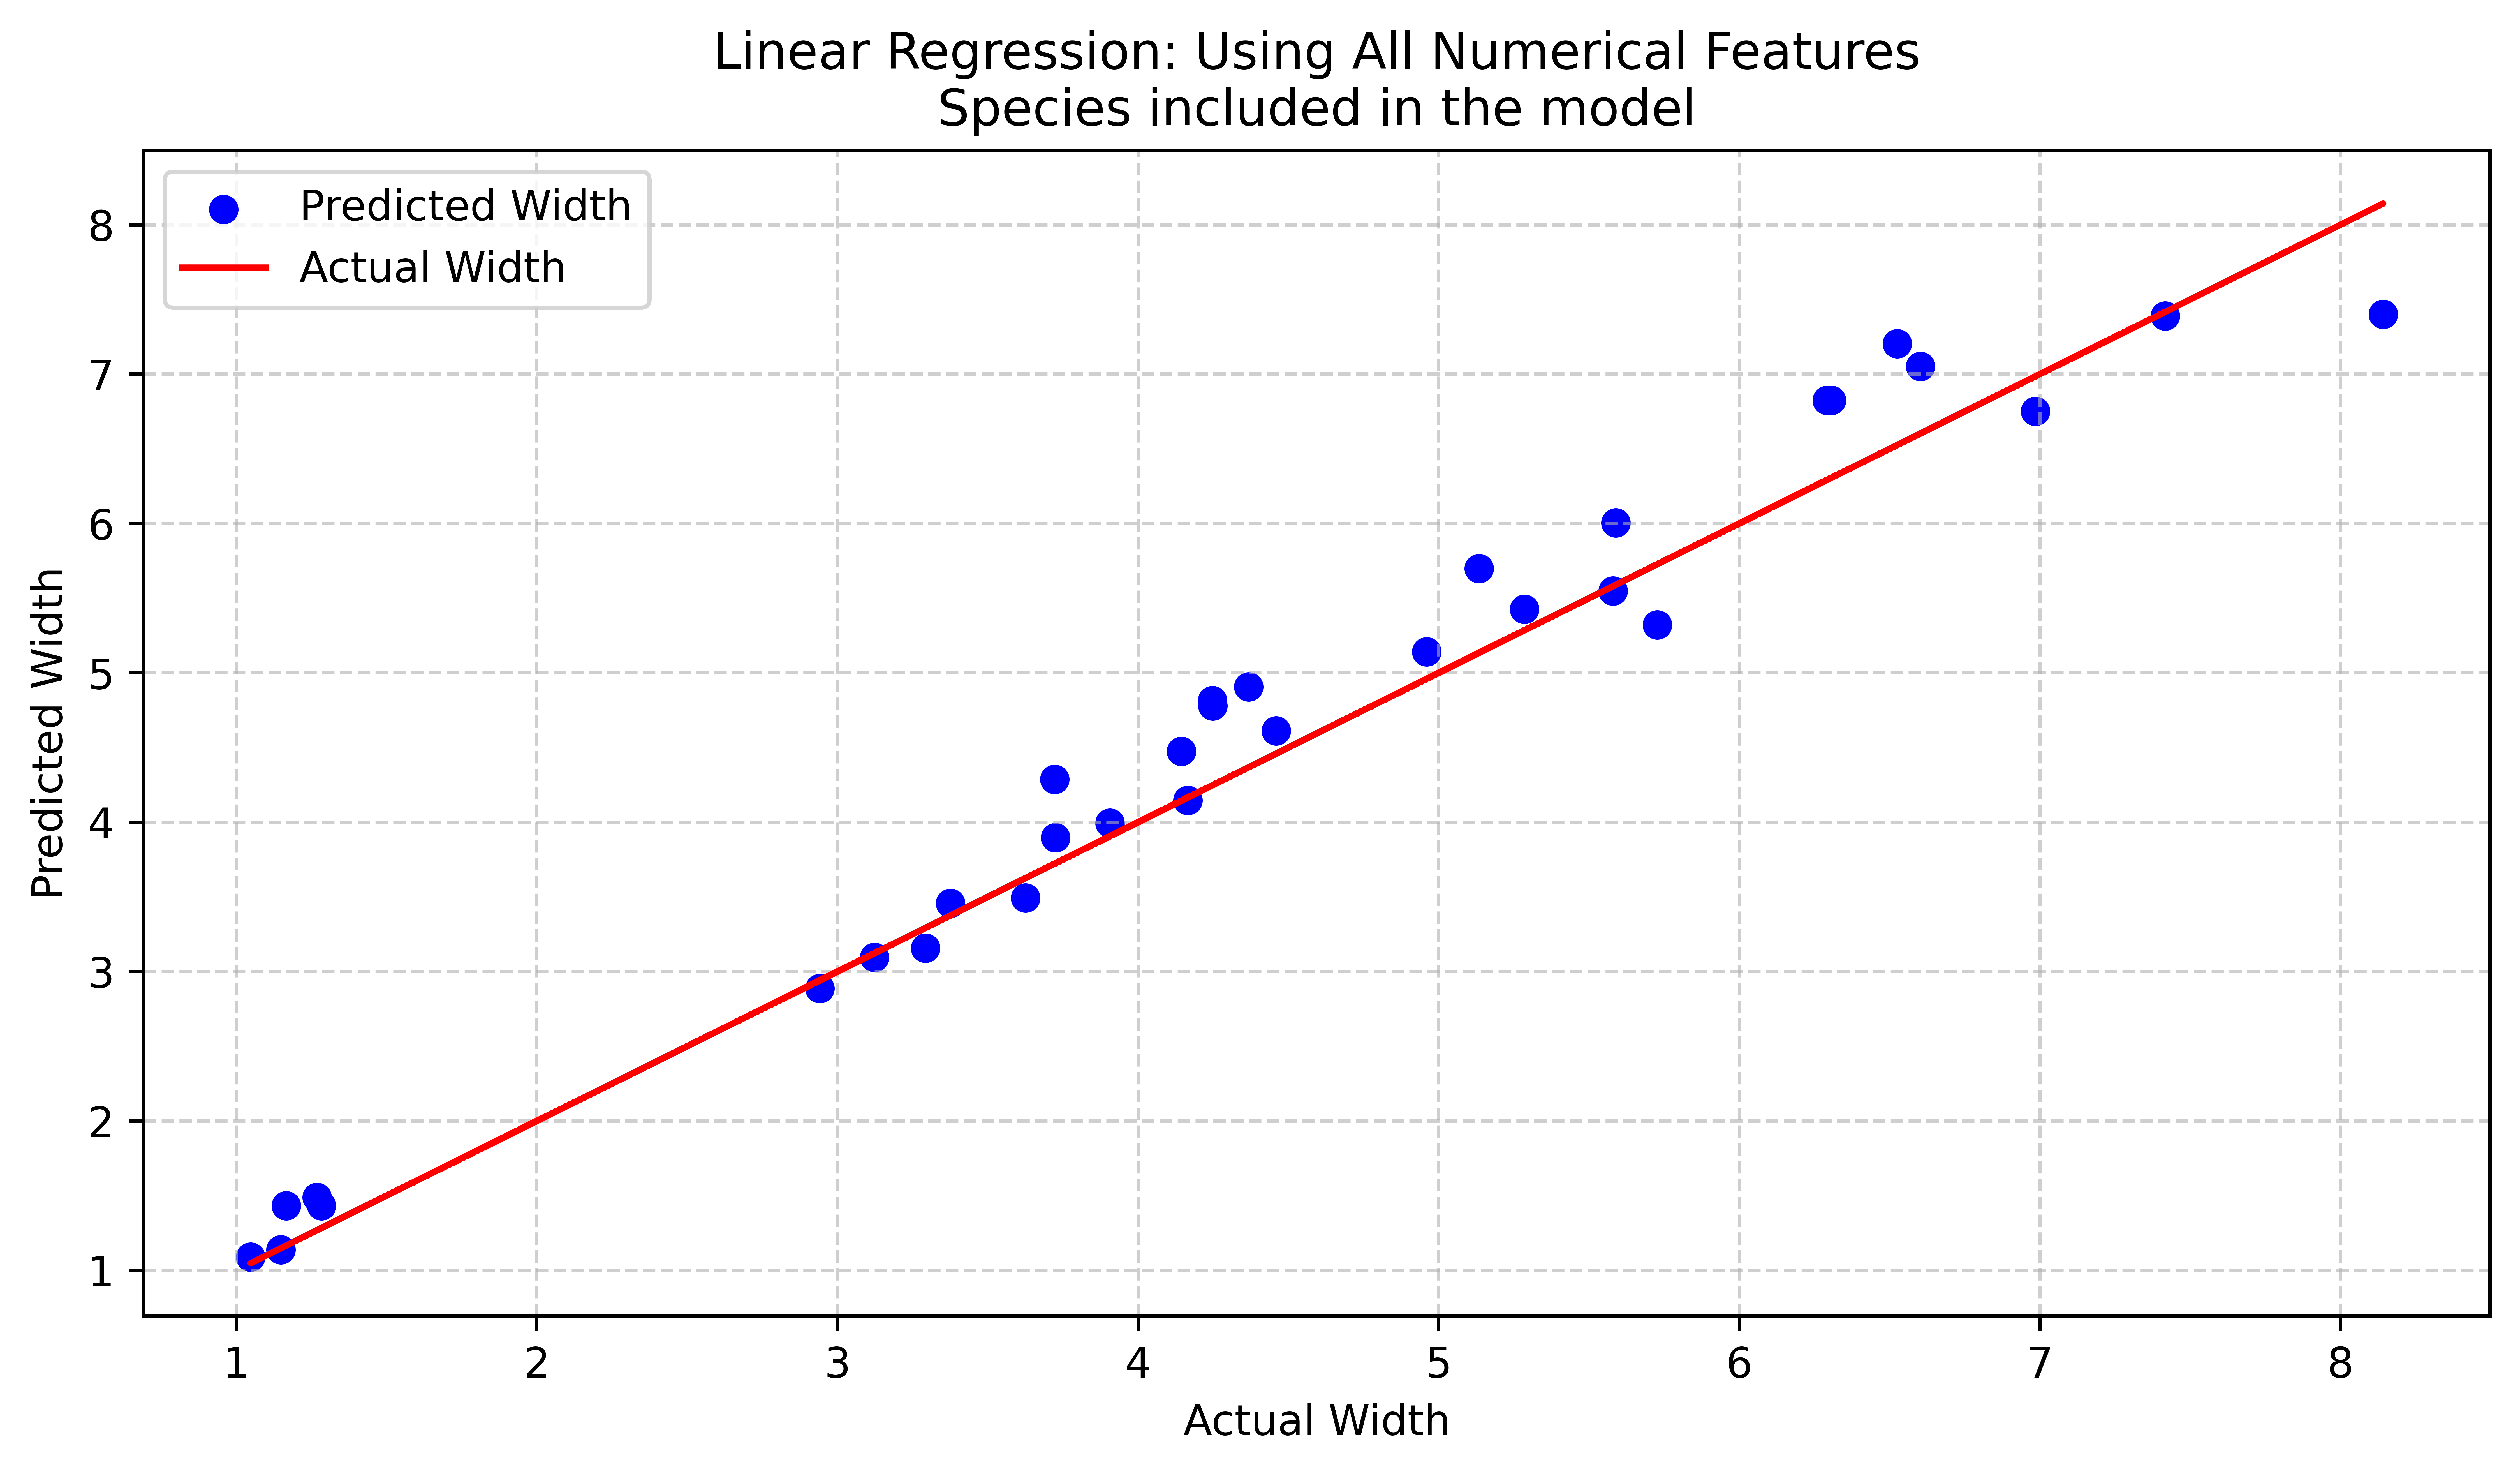

In [78]:
plot_regression(
    y_test, y_pred,
    regression_type='Linear',
    title="Using All Numerical Features\nSpecies included in the model")

### <hr>

Navigate:

| [$\leftarrow$ Linear Regression 1 ](n1_linear_regression_1.ipynb) | [Polynomial Regression $\rightarrow$](n3_polynomial_regression.ipynb) |
| :-----------------------------------------------------------------: | :---------------------------------------------------------------: |
